<a href="https://colab.research.google.com/github/MammadovN/Machine_Learning/blob/main/projects/03_deep_learning/recurrent_neural_networks/BIO_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!pip install biopython

In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from google.colab import files
import requests
import gzip
import io
from Bio import SeqIO
import random

In [59]:
# Dictionary to convert amino acids to numerical values
AMINO_ACIDS = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
    'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20,
    'X': 0, 'U': 0, 'O': 0, 'B': 0, 'Z': 0, 'J': 0, '-': 0, '*': 0
}

# Function to generate random protein data (for testing instead of real data)
def generate_dummy_data(n_samples=1000, max_seq_length=500, n_classes=10):
    """
    Generates synthetic protein data for testing purposes.
    """
    amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
    functions = [f'Function_{i}' for i in range(n_classes)]

    data = []
    for i in range(n_samples):
        # Generate a protein sequence of random length
        seq_len = random.randint(50, max_seq_length)
        sequence = ''.join(random.choices(amino_acids, k=seq_len))

        # Assign a random function label
        function = random.choice(functions)

        data.append({
            'protein_id': f'P{i:05d}',
            'sequence': sequence,
            'function': function
        })

    return pd.DataFrame(data)

In [60]:
# Function to preprocess protein data
def preprocess_sequences(df, max_length=1000):
    """
    Preprocess protein sequences and convert to numerical vectors.
    """
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['function'])

    # Determine maximum sequence length (or use provided parameter)
    if max_length is None:
        max_length = max(len(seq) for seq in df['sequence'])

    # Convert sequences to numerical vectors and pad to equal length
    X = np.zeros((len(df), max_length))

    for i, seq in enumerate(df['sequence']):
        for j, aa in enumerate(seq[:max_length]):
            X[i, j] = AMINO_ACIDS.get(aa, 0)  # Use 0 for unknown amino acids

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, label_encoder

# Download data from UniProt (optional – API limits may apply)
# Download data from UniProt
def download_uniprot_data(query="reviewed:true AND organism_id:9606 AND protein_existence:1", limit=1000):
    """
    Downloads protein data using UniProt API
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": query,
        "format": "tsv",
        "fields": "accession,id,sequence,go_f",
        "size": limit
    }

    try:
        response = requests.get(base_url, params=params, timeout=30)
        response.raise_for_status()  # Raise exception for HTTP errors

        if response.text.strip():  # Check if response has content
            df = pd.read_csv(io.StringIO(response.text), sep='\t')
            # Fix column names
            df.columns = ['protein_id', 'entry_name', 'sequence', 'go_function']
            # Filter out entries without GO terms
            df = df[df['go_function'].notna()]
            # Simplify GO terms – take the first term only
            df['function'] = df['go_function'].apply(
                lambda x: x.split('[')[0].strip() if isinstance(x, str) else 'Unknown'
            )

            return df[['protein_id', 'sequence', 'function']]
        else:
            print("Download returned empty data")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Data download error: {str(e)}")
        return None

In [61]:
class ProteinDataset(Dataset):
    """
    Dataset class containing protein sequences and function labels for PyTorch
    """
    def __init__(self, sequences, labels):
        self.sequences = torch.FloatTensor(sequences)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # return sequence in shape (seq_len, 1) and its label
        return self.sequences[idx].unsqueeze(1), self.labels[idx]

# Function to create DataLoaders for training and testing
def get_dataloaders(X_train, X_test, y_train, y_test, batch_size=32):
    """
    Create DataLoaders for training and test sets.
    """
    train_dataset = ProteinDataset(X_train, y_train)
    test_dataset = ProteinDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [62]:
"""## Model Architecture"""

# LSTM Model Definition
class ProteinLSTM(nn.Module):
    def __init__(
        self,
        input_size: int = 1,
        hidden_size: int = 128,
        num_layers: int = 2,
        num_classes: int = 10,
        dropout: float = 0.5
    ):
        """
        LSTM model for predicting protein function from sequences.

        Args:
            input_size: Number of input features (per amino acid).
            hidden_size: Hidden layer size of the LSTM.
            num_layers: Number of LSTM layers.
            num_classes: Number of output classes (protein functions).
            dropout: Dropout rate.
        """
        super(ProteinLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        # Classification layers
        self.fc1 = nn.Linear(hidden_size * 2, 128)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Input: (batch_size, sequence_length, input_size)

        # Initialize hidden and cell states for LSTM
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))

        # Take the output of the last time step
        out = out[:, -1, :]

        # Classification head
        out = self.fc1(out)
        out = self.batch_norm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [63]:
# Model training function
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10):
    """
    Model training function.
    """
    # Metrics for monitoring training progress
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    # Variables to save the best model
    best_acc = 0.0
    best_model_state = None

    print("Starting training...")
    for epoch in range(num_epochs):
        start_time = time.time()

        # Training mode
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Evaluation mode
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_test_loss = running_loss / len(test_loader.dataset)
        epoch_test_acc = correct / total
        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc)

        epoch_time = time.time() - start_time

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | '
              f'Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.4f} | '
              f'Time: {epoch_time:.2f}s')

        # Save best model
        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            best_model_state = model.state_dict().copy()

    # Load best model state
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Visualize training results
    plot_training_results(train_losses, test_losses, train_accs, test_accs)

    return model, train_losses, test_losses, train_accs, test_accs

In [64]:
def plot_training_results(train_losses, test_losses, train_accs, test_accs):
    """
    Function to visualize training metrics.
    """
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [65]:
def evaluate_model(model, test_loader, criterion, device, label_encoder):
    """
    Model evaluation function.
    """
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_names = label_encoder.classes_

    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Print classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:\n", report)

    return test_acc, test_loss, cm, report

In [66]:
def main():
    # Model hyperparameters
    batch_size = 32
    hidden_size = 128
    num_layers = 2
    dropout = 0.5
    learning_rate = 0.001
    num_epochs = 10
    max_seq_length = 500

    # Check for CUDA availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data loading options
    data_choice = input("Select data source (1: Generate dummy data, 2: Upload file, 3: Download from UniProt): ")

    if data_choice == '1':
        # Generate dummy data
        n_samples = int(input("Number of samples (recommended: 1000): ") or "1000")
        n_classes = int(input("Number of classes (recommended: 10): ") or "10")
        df = generate_dummy_data(n_samples=n_samples, max_seq_length=max_seq_length, n_classes=n_classes)
        print(f"Generated {n_samples} samples with {n_classes} classes.")

    elif data_choice == '2':
        # Upload CSV file
        print("Upload a CSV file (must contain columns: protein_id, sequence, function)")
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        df = pd.read_csv(filename)
        print(f"Loaded file: {filename}, containing {len(df)} samples.")

    elif data_choice == '3':
        # Download from UniProt
        limit = int(input("Number of proteins to download (recommended: 500): ") or "500")
        query = input("UniProt query (leave blank for default): ")
        if not query:
            query = "reviewed:true AND organism_id:9606 AND protein_existence:1"

        print(f"Downloading data from UniProt with query: {query}")
        df = download_uniprot_data(query=query, limit=limit)

        if df is None or len(df) == 0:
            print("Download failed or returned no data. Generating dummy data instead...")
            df = generate_dummy_data(n_samples=1000, max_seq_length=max_seq_length, n_classes=10)
        else:
            print(f"Downloaded {len(df)} protein samples.")

    else:
        print("Invalid choice. Generating dummy data by default...")
        df = generate_dummy_data(n_samples=1000, max_seq_length=max_seq_length, n_classes=10)

    # Quick data summary
    print("\nData Summary:")
    print(f"Total samples: {len(df)}")
    print(f"Function classes: {df['function'].nunique()}")
    print(f"Average sequence length: {df['sequence'].str.len().mean():.1f}")

    # Preprocess data
    print("\nPreprocessing data...")
    X_train, X_test, y_train, y_test, label_encoder = preprocess_sequences(df, max_length=max_seq_length)
    train_loader, test_loader = get_dataloaders(X_train, X_test, y_train, y_test, batch_size=batch_size)

    # Get number of classes
    num_classes = len(label_encoder.classes_)
    print(f"Number of protein function classes: {num_classes}")

    # Initialize model
    model = ProteinLSTM(
        input_size=1,  # One feature per amino acid
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=num_classes,
        dropout=dropout
    ).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Print model summary
    print("\nModel Architecture:")
    print(model)

    # Train the model
    print("\nStarting training...")
    model, train_losses, test_losses, train_accs, test_accs = train_model(
        model, train_loader, test_loader, criterion, optimizer, device,
        num_epochs=num_epochs
    )

    # Evaluate the model
    print("\nEvaluating model...")
    test_acc, test_loss, cm, report = evaluate_model(
        model, test_loader, criterion, device, label_encoder
    )

    # Training results summary
    print(f"\nTraining complete! Best test accuracy: {max(test_accs):.4f}")

    # Save the trained model
    save_choice = input("\nWould you like to save the trained model? (y/n): ")
    if save_choice.lower() == 'y':
        torch.save(model.state_dict(), 'protein_lstm_model.pth')
        files.download('protein_lstm_model.pth')
        print("Model downloaded: protein_lstm_model.pth")

Using device: cuda
Select data source (1: Generate dummy data, 2: Upload file, 3: Download from UniProt): 2
Upload a CSV file (must contain columns: protein_id, sequence, function)


Saving dummy_protein_data.csv to dummy_protein_data.csv
Loaded file: dummy_protein_data.csv, containing 500 samples.

Data Summary:
Total samples: 500
Function classes: 10
Average sequence length: 273.7

Preprocessing data...
Number of protein function classes: 10

Model Architecture:
ProteinLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Starting training...
Starting training...
Epoch 1/10 | Train Loss: 2.4025 | Train Acc: 0.0850 | Test Loss: 2.3128 | Test Acc: 0.0800 | Time: 0.47s
Epoch 2/10 | Train Loss: 2.3781 | Train Acc: 0.1075 | Test Loss: 2.3110 | Test Acc: 0.0900 | Time: 0.39s
Epoch 3/10 | Train Loss: 2.3576 | Train Acc: 0.1100 | Test Loss: 2.3092 | Test

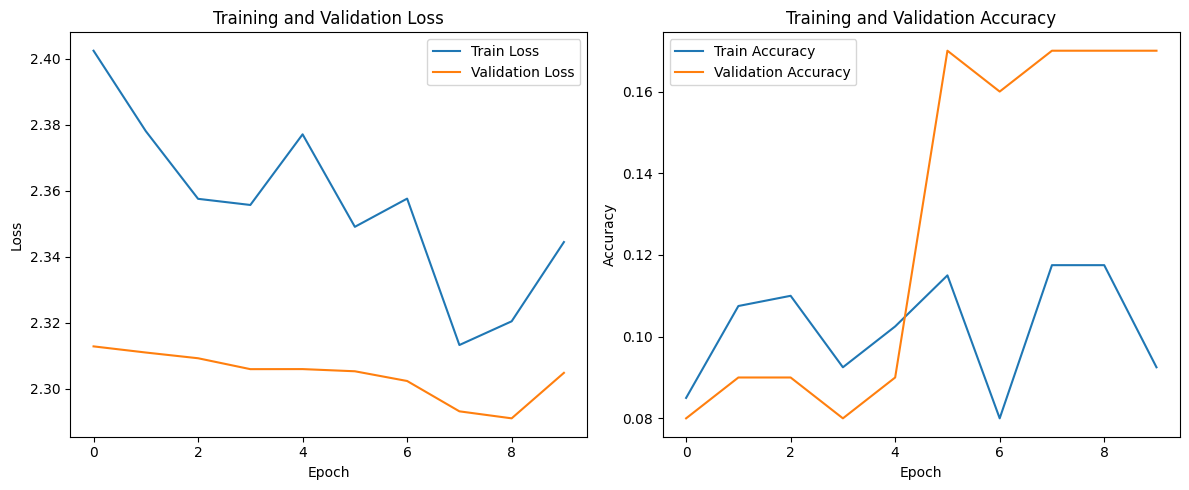


Evaluating model...
Test Accuracy: 0.1700, Test Loss: 2.3048


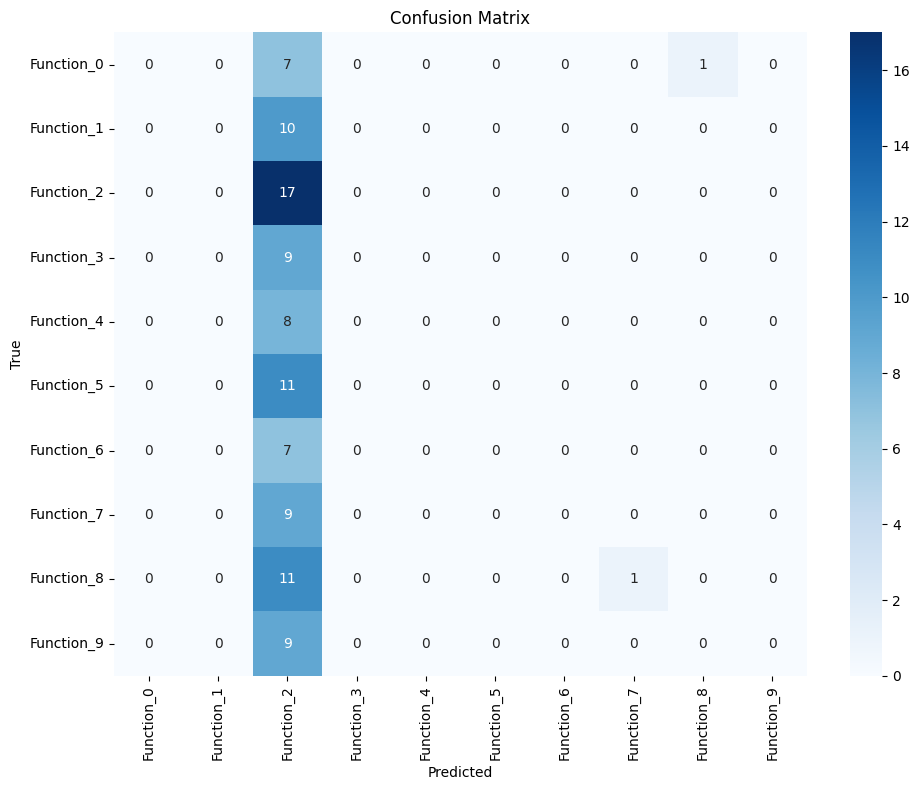

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

  Function_0       0.00      0.00      0.00         8
  Function_1       0.00      0.00      0.00        10
  Function_2       0.17      1.00      0.30        17
  Function_3       0.00      0.00      0.00         9
  Function_4       0.00      0.00      0.00         8
  Function_5       0.00      0.00      0.00        11
  Function_6       0.00      0.00      0.00         7
  Function_7       0.00      0.00      0.00         9
  Function_8       0.00      0.00      0.00        12
  Function_9       0.00      0.00      0.00         9

    accuracy                           0.17       100
   macro avg       0.02      0.10      0.03       100
weighted avg       0.03      0.17      0.05       100


Training complete! Best test accuracy: 0.1700

Would you like to save the trained model? (y/n): n


In [67]:
if __name__ == "__main__":
    main()